# Individual Project Task 2: Self-supervised CT Denoising with Noise2Score
This notebook is provided for self-supervised CT denoising task with Noise2Score.

###Table of Contents
I. Data

II. Network: Amortized Residual Denoising Autoencoder (AR-DAE)

III. Other functions

IV. Training

V. Test

## I. Data

### 1. Google Drive
If you want to use data in your Google drive, you have to mount your google drive first.
It makes possible to load data from the drive, save results in the drive, etc.
If you try to mount Google Drive, a link for authentication code will be given.
Then, follow the link, get your authentication code, and enter your code in the prompt.

In [ ]:
!pip install typing_extensions
!pip install torch
!pip install numpy
!pip3 install Cython
!pip install scipy

In [2]:
import torch
print(torch.cuda.is_available())

True


In [ ]:
# Mount your Google Drive
from google.colab import drive
drive.mount('/content/drive')

Now, define the directory address you're working on.

In [1]:
your_workdir = ''    # change this accordingly!

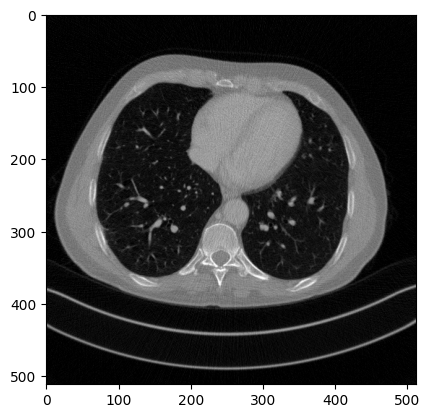

img.shape: (512, 512)


In [24]:
import numpy as np
import matplotlib.pyplot as plt

# Load an example image
img = np.load(your_workdir+'AAPM_data_2025F/train/full_dose/1.npy')

# Change linear attenuation coefficient into HU values
img = (img - 0.0192) / 0.0192 * 1000
# Clip the CT image with [-1000, 1000] HU
img = np.clip(img, -1000, 1000)

# Plot the example image
plt.imshow(img, cmap='gray')
plt.show()

print('img.shape:', img.shape)

### 2. Dataloader
* As we do in cycleGAN, data preprocessing (e.g. cliping, normalization) is required.

In [4]:
offset = 1024/4000    # This value is used in the normalization to make data input non-negative, so that we could inject poission noise

In [5]:
inference_noise_type = 'Poisson'   # 'Gaussian' or 'Poisson'

In [6]:
import torch
import random
from os import listdir
from os.path import join
from torch.utils.data import Dataset

# CT dataset
class CT_Dataset(Dataset):
  def __init__(self, path, phase, transform):
    # Path of 'full_dose' folders
    self.path_full = join(path, 'full_dose')
    self.phase = phase
    self.transform = transform

    # File list of full dose data
    self.file_full = list()
    for file_name in sorted(listdir(self.path_full)):
      self.file_full.append(file_name)

    # random.seed(0)
    # random.shuffle(self.file_full)


  def __len__(self):
    return len(self.file_full)

  def __getitem__(self, idx):
    # Load full dose/quarter dose data
    x_F = np.load(join(self.path_full, self.file_full[idx]))
    # Convert to HU scale
    x_F = (x_F - 0.0192) / 0.0192 * 1000

    # Normalize images
    x_F[x_F < -1000] = -1000

    x_F = x_F / 4000 + offset

    # Apply transform
    x_F = self.transform(x_F)

    if inference_noise_type == 'Gaussian':
      x_F_noisy = x_F + np.random.randn(*x_F.shape)*0.1
    elif inference_noise_type == 'Poisson':
      x_F_noisy = np.random.poisson(x_F/eta) * eta
      x_F_noisy = torch.from_numpy(x_F_noisy).float()

    file_name = self.file_full[idx]
    return x_F, x_F_noisy, file_name

Because the size of CT images is too large, we have to crop the images into small size patches for training.
After training with patches, the whole size image will be used for the test.

In [7]:
import random
import torchvision
from torch.utils.data import DataLoader

# Transform for the random crop
class RandomCrop(object):
  def __init__(self, patch_size):
    self.patch_size = patch_size

  def __call__(self, img):
    # Randomly crop the image into a patch with the size [self.patch_size, self.patch_size]
    w, h = img.size(-1), img.size(-2)
    i = random.randint(0, h - self.patch_size)
    j = random.randint(0, w - self.patch_size)

    return img[:, i:i + self.patch_size, j:j + self.patch_size]

# Make dataloader for training/test
def make_dataloader(path, batch_size, noise_type):
  # Path of 'train' and 'test' folders
  path_train = join(path, 'train')
  path_test = join(path, 'test')

  train_transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.RandomHorizontalFlip(p=0.5),
        torchvision.transforms.RandomVerticalFlip(p=0.5),
        RandomCrop(128)
  ])

  # Transform for test data: convert to tensor
  test_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
  ])

  # Generate CT dataset for training/test
  train_dataset = CT_Dataset(path_train, 'train', train_transform)
  test_dataset = CT_Dataset(path_test, 'test', test_transform)
  print('#data:', len(train_dataset), len(test_dataset))

  # Generate dataloader for training/test
  train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
  test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0, pin_memory=True)

  return train_dataloader, test_dataloader

## II. Network (AR-DAE)

- Noise2Score trains an AR-DAE to estimate the score function of the noisy data
- Let's generate an AR-DAE with a U-Net architecture.
- You may use the same U-Net that you implemented for CycleGAN generator.

In [8]:
import torch.nn as nn

class ConvBlock(nn.Module):
  def __init__(self, in_channels, mid_channels, out_channels):
    super(ConvBlock, self).__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(in_channels, mid_channels, kernel_size=3, stride=1, padding=1, bias=False),
        nn.BatchNorm2d(mid_channels, affine=True, track_running_stats=True),
        nn.ReLU(),
        nn.Conv2d(mid_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
        nn.BatchNorm2d(out_channels, affine=True, track_running_stats=True),
        nn.ReLU()
    )
  def forward(self, x):
    out = self.conv(x)
    return out
class encoder_block(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.conv = ConvBlock(in_channels, out_channels, out_channels)
    self.pool = nn.MaxPool2d((2, 2))
  def forward(self, inputs):
    x = self.conv(inputs)
    p = self.pool(x)
    return x, p 

class decoder_block(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2, padding=0)
    self.conv = ConvBlock(out_channels + out_channels, out_channels, out_channels)
  def forward(self, inputs, skip):
    x = self.up(inputs)
    x = torch.cat([x, skip], axis=1)
    x = self.conv(x)
    return x

# Generator
class UNet(nn.Module):
  def __init__(self, in_channels, out_channels, ngf):
    super(UNet, self).__init__()
    # in_channels: the number of channels of the input
    # out_channels: the number of channels of the output
    # ngf: the number of convolution filters of the first layer
    ######################
    """ Encoder """
    self.enc1 = encoder_block(in_channels, ngf)
    self.enc2 = encoder_block(ngf, ngf*2)
    self.enc3 = encoder_block(ngf*2, ngf*4)
    self.enc4 = encoder_block(ngf*4, ngf*8)
    """ Bottleneck """
    self.bk = ConvBlock(ngf*8, ngf*16, ngf*16)
    """ Decoder """
    self.dec1 = decoder_block(ngf*16, ngf*8)
    self.dec2 = decoder_block(ngf*8, ngf*4)
    self.dec3 = decoder_block(ngf*4, ngf*2)
    self.dec4 = decoder_block(ngf*2, ngf)
    """ Output """
    self.outputs = nn.Conv2d(ngf, out_channels, kernel_size=1, padding=0)
    ######################

  def forward(self, x):
    ######################
    """ Encoder """
    s1, p1 = self.enc1(x)
    s2, p2 = self.enc2(p1)
    s3, p3 = self.enc3(p2)
    s4, p4 = self.enc4(p3)
    """ Bottleneck """
    b = self.bk(p4)
    """ Decoder """
    d1 = self.dec1(b, s4)
    d2 = self.dec2(d1, s3)
    d3 = self.dec3(d2, s2)
    d4 = self.dec4(d3, s1)
    """ Outputs """
    res = self.outputs(d4)
    out = res + x
    ######################
    return out

 ## III. Other Functions

In [9]:
from torch.nn import init
import matplotlib.pyplot as plt

def init_weights(net, init_type='normal', init_gain=0.02):
    def init_func(m):  # define the initialization function
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
            if init_type == 'normal':
                init.normal_(m.weight.data, 0.0, init_gain)
            elif init_type == 'xavier':
                init.xavier_normal_(m.weight.data, gain=init_gain)
            elif init_type == 'kaiming':
                init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
            elif init_type == 'orthogonal':
                init.orthogonal_(m.weight.data, gain=init_gain)
            else:
                raise NotImplementedError('initialization method [%s] is not implemented' % init_type)
            if hasattr(m, 'bias') and m.bias is not None:
                init.constant_(m.bias.data, 0.0)
        elif classname.find('BatchNorm2d') != -1:  # BatchNorm Layer's weight is not a matrix; only normal distribution applies.
            init.normal_(m.weight.data, 1.0, init_gain)
            init.constant_(m.bias.data, 0.0)

    print('initialize network with %s' % init_type)
    net.apply(init_func)  # apply the initialization function <init_func>

def init_net(net, init_type='normal', init_gain=0.02, gpu_ids=[]):
    """Initialize a network: 1. register CPU/GPU device (with multi-GPU support); 2. initialize the network weights
    Parameters:
        net (network)      -- the network to be initialized
        init_type (str)    -- the name of an initialization method: normal | xavier | kaiming | orthogonal
        gain (float)       -- scaling factor for normal, xavier and orthogonal.
        gpu_ids (int list) -- which GPUs the network runs on: e.g., 0,1,2

    Return an initialized network.
    """
    if len(gpu_ids) > 0:
        assert(torch.cuda.is_available())
        net.to(gpu_ids[0])
        net = torch.nn.DataParallel(net, gpu_ids)  # multi-GPUs
    init_weights(net, init_type, init_gain=init_gain)
    return net

# Calculate average loss during one epoch
class Mean:
  def __init__(self):
    self.numel = 0
    self.mean = 0

  def __call__(self, val):
    self.mean = self.mean * (self.numel / (self.numel + 1)) + val / (self.numel + 1)
    self.numel += 1

  def result(self):
    return self.mean


# Show input and output images during training
def show_images(imgs):
  NGR= np.concatenate(imgs[:3], axis=2)
  img_array = np.squeeze(NGR)
  img_array = img_array * 2000
  img_array = img_array - 1000
  img_array = np.clip(img_array, -1000, 1000)

  plt.imshow(img_array, cmap='gray')
  plt.show()

## IV. Training

### Hyperparameter Setting

- Before training the network, some hyperparameters should be defined as follows.
- Experiment with the hyperparameters to observe how they affect the model performance.

In [10]:
import numpy as np
import torch
import torch.nn.functional as F
import torch.optim as optim
from os import makedirs
from os.path import isdir

# Hyperparameters
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

batch_size = 32
num_epoch = 100

###Optimizer
beta1 = 0.05
beta2 = 0.999
lr = 4e-4

###NOISE scale for AR-DAE training
sigma_min = 0.0
sigma_max = 0.2

###FOR POISSON NOISE
eta = 0.01

print(device)

# Path for saving the checkpoint
path_checkpoint = your_workdir + 'CT_denoising'
if not isdir(path_checkpoint):
  makedirs(path_checkpoint)

cuda:3


```model_name``` is the name of the model, and it will be used for saving the model.
If you want to continue the training from the last checkpoint, set ```model_name``` as the name of the saved model.
However, if you want to train a new model, you have to change ```model_name```.

In [13]:
model_name = 'Noise2Score'

# Path for saving results
path_result = join(path_checkpoint, model_name)
if not isdir(path_result):
  makedirs(path_result)

Next, make dataloaders, networks, optimizers, and define loss functions.

- MSE loss is used to train the AR-DAE



In [12]:
path_data = your_workdir + 'AAPM_data_2025F'

train_dataloader, test_dataloader = make_dataloader(path_data, batch_size, 'Gaussian')

####################
ARDAE = UNet(1, 1, 64).to(device)
####################

ARDAE = init_net(ARDAE, init_type='normal', init_gain=0.02, gpu_ids=[3])

optimizer = torch.optim.Adam(ARDAE.parameters(), lr=lr, betas=(beta1, beta2))


criterion = nn.MSELoss()

loss_name = ['loss_score', ]

#data: 1919 100
initialize network with normal


###  Training

- You have to inject certain level of noise into the clean data, and feed it into AR-DAE.
- Fill in the below code to complete score estimation loss and its training.

In [14]:
from os.path import isfile
from tqdm.auto import tqdm
import random

if isfile(join(path_checkpoint, model_name + '.pth')):
    checkpoint = torch.load(join(path_checkpoint, model_name + '.pth'), map_location=device)
    ARDAE.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    trained_epoch = checkpoint['epoch']
    losses_list = {name: torch.load(join(path_result, name + '.npy')) for name in loss_name}
    print('Start from save model - ' + str(trained_epoch))

else:
    trained_epoch = 0
    losses_list = {name: list() for name in loss_name}
    print('Start from random initialized model')

total_iters = 0

for epoch in tqdm(range(trained_epoch, num_epoch), desc='Epoch', total=num_epoch, initial=trained_epoch):
    losses = {name: Mean() for name in loss_name}
    ARDAE.train()

    epoch_iter = 0
    for _, x_F_input, _ in tqdm(train_dataloader, desc='Step'):
        x_F_input = x_F_input.to(device)

        epoch_iter += batch_size

        sigma = (torch.rand(x_F_input.shape[0])*sigma_max).unsqueeze(-1).unsqueeze(-1).unsqueeze(-1).to(device)
        ########################################
        noise = torch.randn_like(x_F_input)
        x_F_noised = x_F_input + sigma * noise
        output = ARDAE(x_F_noised)
        loss = nn.MSELoss()(noise + sigma * output, torch.zeros_like(output))
        x_F_recon = (x_F_noisy + 0.5*eta) * torch.exp(eta*output)
        ########################################

        ###COMPUTE LOSS###
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        losses['loss_score'](loss.item())

    for name in loss_name:
        losses_list[name].append(losses[name].result())

    print('Epoch: %d, Loss_score: %.4f' % (epoch, sum(losses_list['loss_score'])/len(losses_list['loss_score'])))

    torch.save({'epoch': epoch + 1, 'model_state_dict': ARDAE.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}, join(path_checkpoint, model_name + '.pth'))
    for name in loss_name:
        torch.save(losses_list[name], join(path_result, name + '.npy'))

    if (epoch + 1) % 10 == 0:
        show_images([x_F_input[0].detach().cpu().numpy(),x_F_recon[0].detach().cpu()])

Start from save model - 100


Epoch: 100%|##########| 100/100 [00:00<?, ?it/s]

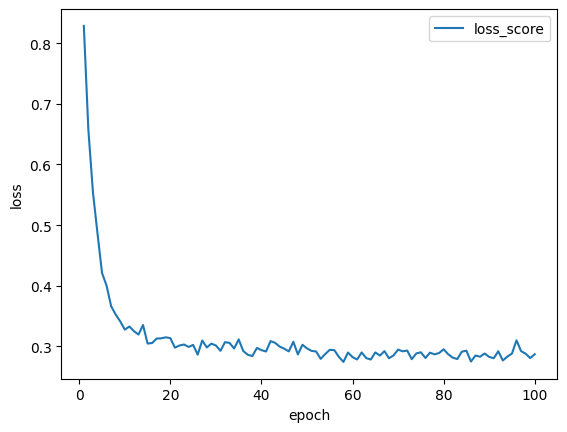

In [15]:
import matplotlib.pyplot as plt

# Plot loss graph (loss_score)
plt.figure(1)

loss_arr = torch.load(join(path_result, 'loss_score'+ '.npy'), map_location=device)
x_axis = np.arange(1, len(loss_arr)+1)

plt.plot(x_axis, loss_arr, label='loss_score')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(loc='upper right')
plt.savefig(join(path_result, 'loss_curve_1.png'))
plt.show()

# V. Test

*   Noise2Score allows denoising an image corrupted with any exponential family.
*   For this project, we intend to denoise a CT image corrupted with a ***Poisson Noise with a known noise level of ζ = 0.01***
* Complete the inference code to apply tweedie formula into the given noise image for Poisson noise.
- Save the noisy images and the reconstructed images from the test set to verify the model performance

In [17]:
from tqdm.auto import tqdm

# Test and save
path_result_recon = join(path_result, '_recon')
if not isdir(path_result_recon):
    makedirs(path_result_recon)
path_result_noisy = join(path_result, '_noisy')
if not isdir(path_result_noisy):
    makedirs(path_result_noisy)


# Load the last checkpoint
checkpoint = torch.load(join(path_checkpoint, model_name + '.pth'), map_location=device)
ARDAE.load_state_dict(checkpoint['model_state_dict'])
ARDAE.eval()

with torch.no_grad():
  for x_F, x_F_noisy, file_name in tqdm(test_dataloader):
    x_F_noisy = x_F_noisy.to(device)

    if inference_noise_type == 'Gaussian':
      x_F_recon = x_F_noisy + 0.1**2*ARDAE(x_F_noisy)
    if inference_noise_type == 'Poisson':
      ########################################
      x_F_recon = (x_F_noisy + 0.5*eta) * torch.exp(eta*ARDAE(x_F_noisy))
      ########################################

    x_F_noisy = x_F_noisy[0].detach().cpu().numpy()
    x_F_recon = x_F_recon[0].detach().cpu().numpy()

    x_F_noisy = (x_F_noisy-offset) * 4000
    x_F_recon = (x_F_recon-offset) * 4000

    np.save(join(path_result_noisy, file_name[0]), x_F_noisy)
    np.save(join(path_result_recon, file_name[0]), x_F_recon)

  0%|          | 0/100 [00:00<?, ?it/s]

In [19]:
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

# Functions for caculating PSNR, SSIM
def psnr(A, ref):
  ref[ref < -1000] = -1000
  A[A < -1000] = -1000
  val_min = -1000
  val_max = np.amax(ref)
  ref = (ref - val_min) / (val_max - val_min)
  A = (A - val_min) / (val_max - val_min)
  out = peak_signal_noise_ratio(ref, A)
  return out

def ssim(A, ref):
  ref[ref < -1000] = -1000
  A[A < -1000] = -1000
  val_min = -1000
  val_max = np.amax(ref)
  ref = (ref - val_min) / (val_max - val_min)
  A = (A - val_min) / (val_max - val_min)
  out = structural_similarity(ref, A, data_range=2)
  return out

Noisy input PSNR: 30.18492059879883
Noisy input SSIM: 0.8640433775923093
Denoised output PSNR: 37.87881028400853
Denoised output SSIM: 0.9648803655966


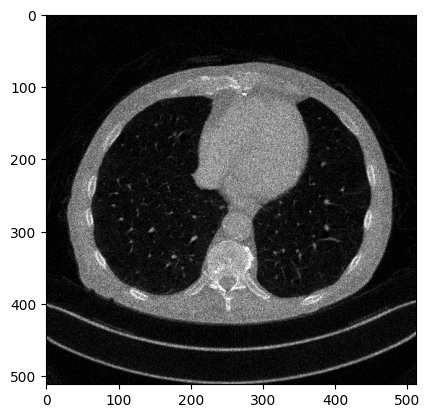

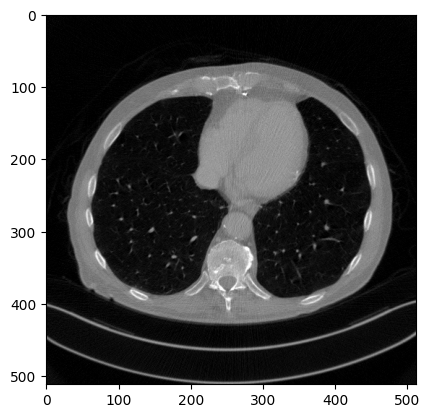

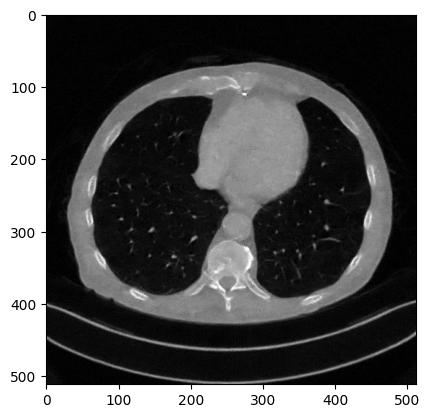

In [22]:
# How to use functions 'psnr' and 'ssim'
path_full = join(path_data, 'test/full_dose/1.npy')
path_noisy = join(path_result_noisy, '1.npy')
path_output = join(path_result_recon, '1.npy')

full = np.load(path_full)
noisy = np.load(path_noisy)[0]
output = np.load(path_output)[0]

full = (full - 0.0192) / 0.0192 * 1000

print('Noisy input PSNR:', psnr(noisy, full))
print('Noisy input SSIM:', ssim(noisy, full))
print('Denoised output PSNR:', psnr(output, full))
print('Denoised output SSIM:', ssim(output, full))

noisy = np.clip(noisy, -1000, 1000)
full = np.clip(full, -1000, 1000)
output = np.clip(output, -1000, 1000)

plt.imshow(noisy, cmap='gray')
plt.show()
plt.imshow(full, cmap='gray')
plt.show()
plt.imshow(output, cmap='gray')
plt.show()

Calculate mean PSNR and SSIM of Noised image and Noise2Score output for the entire test set, and see the perforance difference.

In [23]:
path_full_dir = join(path_data, 'test/full_dose')

psnr_all_noisy = []
ssim_all_noisy = []
psnr_all_recon = []
ssim_all_recon = []

for full_img in tqdm(listdir(path_full_dir)):

    path_full = join(path_full_dir, full_img)
    path_output = join(path_result_recon, full_img)
    path_noisy = join(path_result_noisy, full_img)

    ###########################
    # Your code
    full = np.load(path_full)
    noisy = np.load(path_noisy)[0]
    output = np.load(path_output)[0]

    full = (full - 0.0192) / 0.0192 * 1000

    psnr_all_noisy.append(psnr(noisy, full))
    ssim_all_noisy.append(ssim(noisy, full))
    psnr_all_recon.append(psnr(output, full))
    ssim_all_recon.append(ssim(output, full))

    ###########################

print('Average Noisy input PSNR:', np.mean(psnr_all_noisy))
print('Average Noisy input SSIM:', np.mean(ssim_all_noisy))
print('Average Denoised output PSNR:', np.mean(psnr_all_recon))
print('Average Denoised output SSIM:', np.mean(ssim_all_recon))

  0%|          | 0/100 [00:00<?, ?it/s]

Average Noisy input PSNR: 25.574956278668257
Average Noisy input SSIM: 0.7309887665375311
Average Denoised output PSNR: 34.27972857427994
Average Denoised output SSIM: 0.9256489648405676
